In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import copy
import matplotlib.pyplot as plt

# Аугментация изображений

In [36]:
# Небольшая обрезка и поворот
augment = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(10, translate=(0.1, 0.1)),
    transforms.ToTensor()
])

In [37]:
# Загрузка датасета без меток
train_data = datasets.MNIST(root="./data", train=True, transform=augment, download=True)
train_loader = DataLoader(train_data, batch_size=256, shuffle=True)

# Архитектура энкодера

In [38]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # 14x14 -> 7x7
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc = nn.Linear(64 * 7 * 7, 256)  # эмбеддинг 256

    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)

# Проекционная и предсказательная голова

In [39]:
class ProjectionHead(nn.Module):
    def __init__(self, in_dim=256, hidden_dim=256, out_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        return self.net(x)

class PredictionHead(nn.Module):
    """Только у ученика"""
    def __init__(self, in_dim=128, hidden_dim=256, out_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        return self.net(x)

# Определение модели

In [40]:
class MiniBYOL(nn.Module):
    def __init__(self, tau=0.99):
        super().__init__()
        # Ученик
        self.encoder_s = Encoder()
        self.projector_s = ProjectionHead()
        self.predictor_s = PredictionHead()

        # Учитель (копия ученика, без градиентов)
        self.encoder_t = copy.deepcopy(self.encoder_s)
        self.projector_t = copy.deepcopy(self.projector_s)
        for p in self.encoder_t.parameters():
            p.requires_grad = False
        for p in self.projector_t.parameters():
            p.requires_grad = False

        self.tau = tau

    @torch.no_grad()
    def update_teacher(self):
        """EMA-обновление параметров учителя"""
        for param_t, param_s in zip(self.encoder_t.parameters(), self.encoder_s.parameters()):
            param_t.data = self.tau * param_t.data + (1 - self.tau) * param_s.data
        for param_t, param_s in zip(self.projector_t.parameters(), self.projector_s.parameters()):
            param_t.data = self.tau * param_t.data + (1 - self.tau) * param_s.data

    def forward(self, x1, x2):
        """Возвращает loss BYOL"""
        # --- Ученик ---
        z1_s = self.projector_s(self.encoder_s(x1))
        z2_s = self.projector_s(self.encoder_s(x2))
        p1 = self.predictor_s(z1_s)
        p2 = self.predictor_s(z2_s)

        # --- Учитель ---
        with torch.no_grad():
            z1_t = self.projector_t(self.encoder_t(x1))
            z2_t = self.projector_t(self.encoder_t(x2))

        # --- Потеря: косинусная близость ---
        loss1 = 2 - 2 * F.cosine_similarity(p1, z2_t.detach(), dim=-1).mean()
        loss2 = 2 - 2 * F.cosine_similarity(p2, z1_t.detach(), dim=-1).mean()
        return (loss1 + loss2) / 2


# Обучение модели

Эпоха 1, loss = 0.0000
Эпоха 2, loss = 0.0000
Эпоха 3, loss = 0.0000
Эпоха 4, loss = 0.0000
Эпоха 5, loss = 0.0000
Эпоха 6, loss = 0.0000
Эпоха 7, loss = 0.0000
Эпоха 8, loss = 0.0000
Эпоха 9, loss = 0.0000
Эпоха 10, loss = 0.0000
Эпоха 11, loss = 0.0000
Эпоха 12, loss = 0.0000
Эпоха 13, loss = 0.0000
Эпоха 14, loss = 0.0000
Эпоха 15, loss = 0.0000
Эпоха 16, loss = 0.0000
Эпоха 17, loss = 0.0000
Эпоха 18, loss = 0.0000
Эпоха 19, loss = 0.0000
Эпоха 20, loss = 0.0000


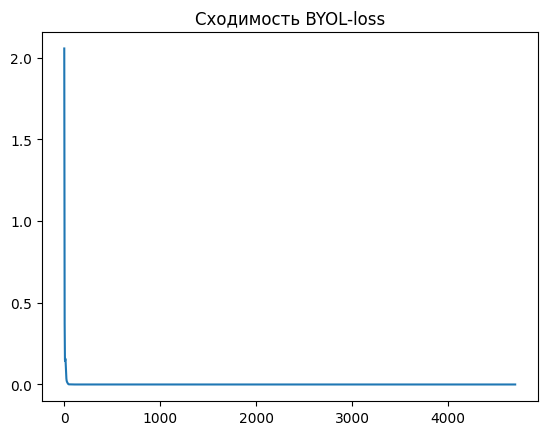

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MiniBYOL(tau=0.98).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

losses = []
for epoch in range(20):  
    for imgs, _ in train_loader:
        # создаём две аугментации для каждого изображения
        x1 = imgs[torch.randperm(imgs.size(0))].to(device)
        x2 = imgs[torch.randperm(imgs.size(0))].to(device)  # простое перемешивание для разнообразия

        loss = model(x1, x2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model.update_teacher()

        losses.append(loss.item())

    print(f"Эпоха {epoch+1}, loss = {loss.item():.4f}")

plt.plot(losses)
plt.title("Сходимость BYOL-loss")
plt.show()

# Заморозка эмбеддингов и линейная голова

In [42]:
# Загружаем стандартный MNIST с ToTensor
test_data = datasets.MNIST(root="./data", train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(test_data, batch_size=256)

# Замораживаем энкодер
for p in model.encoder_s.parameters():
    p.requires_grad = False

# Простая линейная голова
linear_head = nn.Linear(256, 10).to(device)
optimizer = torch.optim.Adam(linear_head.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Тренируем только линейную голову
for epoch in range(3):
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            feats = model.encoder_s(imgs)
        preds = linear_head(feats)
        loss = criterion(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Эпоха {epoch+1}, loss = {loss.item():.4f}")

# Проверяем точность
correct, total = 0, 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        feats = model.encoder_s(imgs)
        preds = linear_head(feats)
        pred_labels = preds.argmax(dim=1)
        correct += (pred_labels == labels).sum().item()
        total += labels.size(0)

print(f"\n✅ Точность линейной головы: {100 * correct / total:.2f}%")

Эпоха 1, loss = 2.3243
Эпоха 2, loss = 2.3216
Эпоха 3, loss = 2.2270

✅ Точность линейной головы: 26.17%


# Шайтан визуализация

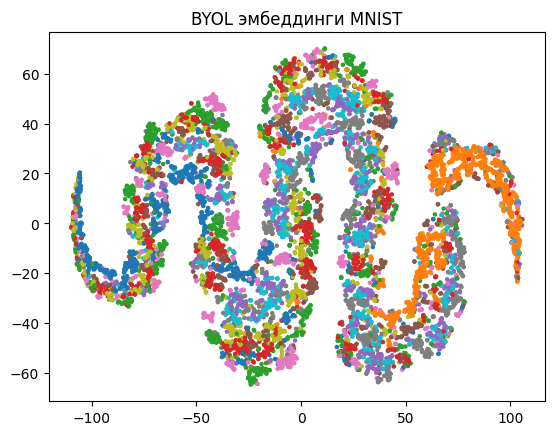

In [43]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

model.encoder_s.eval()
features, labels = [], []
for imgs, lbls in test_loader:
    with torch.no_grad():
        feats = model.encoder_s(imgs.to(device))
    features.append(feats.cpu())
    labels.append(lbls)
features = torch.cat(features)
labels = torch.cat(labels)

tsne = TSNE(n_components=2).fit_transform(features)
plt.scatter(tsne[:,0], tsne[:,1], c=labels, cmap='tab10', s=5)
plt.title("BYOL эмбеддинги MNIST")
plt.show()

1. Что оз